In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
import hvplot.pandas

---
***Graph Parameters***

In [2]:
from matplotlib import cycler
plt.rc('axes', facecolor='navajowhite', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='black', linestyle='solid')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.rcParams["text.color"] = "blue"
plt.rcParams["figure.titlesize"] = "large"
plt.rcParams["figure.figsize"] = 16,9

 #  A Whale off the Port(folio)

 In this assignment, you'll get to use what you've learned this week to evaluate the performance among various algorithmic, hedge, and mutual fund portfolios and compare them against the S&P 500.

---
***First Section***
## Whale Returns

Read the Whale Portfolio daily returns and clean the data

In [3]:
whale_returns_csv = pd.read_csv("Starter_Code/Resources/whale_returns.csv",
                                index_col="Date"
                               ,infer_datetime_format=True
                               ,parse_dates=True)
whale_returns_csv.sort_index(inplace=True)
whale_returns_csv.head()

SOROS FUND MANAGEMENT LLC  PAULSON & CO.INC.   \
Date                                                        
2015-03-02                        NaN                 NaN   
2015-03-03                  -0.001266           -0.004981   
2015-03-04                   0.002230            0.003241   
2015-03-05                   0.004016            0.004076   
2015-03-06                  -0.007905           -0.003574   

            TIGER GLOBAL MANAGEMENT LLC  BERKSHIRE HATHAWAY INC  
Date                                                             
2015-03-02                          NaN                     NaN  
2015-03-03                    -0.000496               -0.006569  
2015-03-04                    -0.002534                0.004213  
2015-03-05                     0.002355                0.006726  
2015-03-06                    -0.008481               -0.013098

* ***Count Null Values***

In [4]:
whale_returns_csv.isnull().sum()

SOROS FUND MANAGEMENT LLC      1
PAULSON & CO.INC.              1
TIGER GLOBAL MANAGEMENT LLC    1
BERKSHIRE HATHAWAY INC         1
dtype: int64

* ***Drop Null Values***

In [5]:
whale_returns_csv.dropna(inplace=True)
whale_returns_csv.isnull().sum()

SOROS FUND MANAGEMENT LLC      0
PAULSON & CO.INC.              0
TIGER GLOBAL MANAGEMENT LLC    0
BERKSHIRE HATHAWAY INC         0
dtype: int64

## Algorithmic Daily Returns

Read the algorithmic daily returns and clean the data

In [6]:
algo_returns_csv = pd.read_csv("Starter_Code/Resources/algo_returns.csv",
                              index_col="Date"
                               ,infer_datetime_format=True
                               ,parse_dates=True)
algo_returns_csv.sort_index(inplace=True)
algo_returns_csv.head()

Algo 1  Algo 2
Date                        
2014-05-28  0.001745     NaN
2014-05-29  0.003978     NaN
2014-05-30  0.004464     NaN
2014-06-02  0.005692     NaN
2014-06-03  0.005292     NaN

* ***Count Null Values***

In [7]:
algo_returns_csv.isnull().sum()

Algo 1    0
Algo 2    6
dtype: int64

* ***Drop null values, and parse dates***

In [8]:
algo_returns_csv.dropna(inplace=True)
algo_returns_csv.isnull().sum()

Algo 1    0
Algo 2    0
dtype: int64

## S&P 500 Returns

Read the S&P500 Historic Closing Prices and create a new daily returns DataFrame from the data. 

In [9]:
sp500_history_csv_original= pd.read_csv("Starter_Code/Resources/sp500_history.csv",
                                       index_col="Date"
                               ,infer_datetime_format=True
                               ,parse_dates=True)
sp500_history_csv_copy = sp500_history_csv_original.sort_index().rename(columns={"Close":"SP500"}).copy()
sp500_history_csv_copy.head()

SP500
Date                
2012-10-01  $1444.49
2012-10-02  $1445.75
2012-10-03  $1450.99
2012-10-04  $1461.40
2012-10-05  $1460.93

* ***Check Data Types***

In [10]:
sp500_history_csv_copy.dtypes

SP500    object
dtype: object

* ***Fix the data types by Removing the dollar signs from the numeric values and convert the data types as needed.***

In [11]:
sp500_history_csv_copy["SP500"] = sp500_history_csv_copy["SP500"].str.replace("$", " ")
sp500_history_csv_copy=pd.to_numeric(sp500_history_csv_copy["SP500"]).to_frame()
sp500_history_csv_copy.dtypes

SP500    float64
dtype: object

* ***Calculate Daily Returns***

In [12]:
sp500_history_daily = sp500_history_csv_copy.pct_change()
sp500_history_daily.head()

SP500
Date                
2012-10-01       NaN
2012-10-02  0.000872
2012-10-03  0.003624
2012-10-04  0.007174
2012-10-05 -0.000322

### Join `Whale Returns`, `Algorithmic Returns`, and the `S&P 500 Returns` into a single DataFrame with columns for each portfolio's returns.

In [13]:
return_daily_concat = pd.concat([whale_returns_csv,algo_returns_csv,sp500_history_daily], axis=1, join="inner")
return_daily_concat.rename(columns={"SOROS FUND MANAGEMENT LLC": "Soros", 
                                    "BERKSHIRE HATHAWAY INC":"Berk", 
                                    "PAULSON & CO.INC. ":"Paul", 
                                    "TIGER GLOBAL MANAGEMENT LLC":"Tiger"},
                                    inplace=True)
return_daily_concat.head()

Soros      Paul     Tiger      Berk    Algo 1    Algo 2  \
Date                                                                     
2015-03-03 -0.001266 -0.004981 -0.000496 -0.006569 -0.001942 -0.000949   
2015-03-04  0.002230  0.003241 -0.002534  0.004213 -0.008589  0.002416   
2015-03-05  0.004016  0.004076  0.002355  0.006726 -0.000955  0.004323   
2015-03-06 -0.007905 -0.003574 -0.008481 -0.013098 -0.004957 -0.011460   
2015-03-09  0.000582  0.004225  0.005843 -0.001652 -0.005447  0.001303   

               SP500  
Date                  
2015-03-03 -0.004539  
2015-03-04 -0.004389  
2015-03-05  0.001196  
2015-03-06 -0.014174  
2015-03-09  0.003944

### Extra for me 

In [14]:
Tiger = "TIGER GLOBAL MANAGEMENT LLC"
Soros = "SOROS FUND MANAGEMENT LLC"
Paul = "PAULSON & CO.INC. "
Berk = "BERKSHIRE HATHAWAY INC"
Tiger_df = return_daily_concat["Tiger"]
Paul_df = return_daily_concat["Paul"]
Soros_df = return_daily_concat["Soros"]
Berk_df = return_daily_concat["Berk"]
Algo1_df =  return_daily_concat["Algo 1"]
Algo2_df = return_daily_concat["Algo 2"]
SP500 = return_daily_concat["SP500"]

---
---

# Portfolio Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

## Performance

Calculate and Plot the daily returns and cumulative returns. Does any portfolio outperform the S&P 500? 

* ***Plot the daily returns***

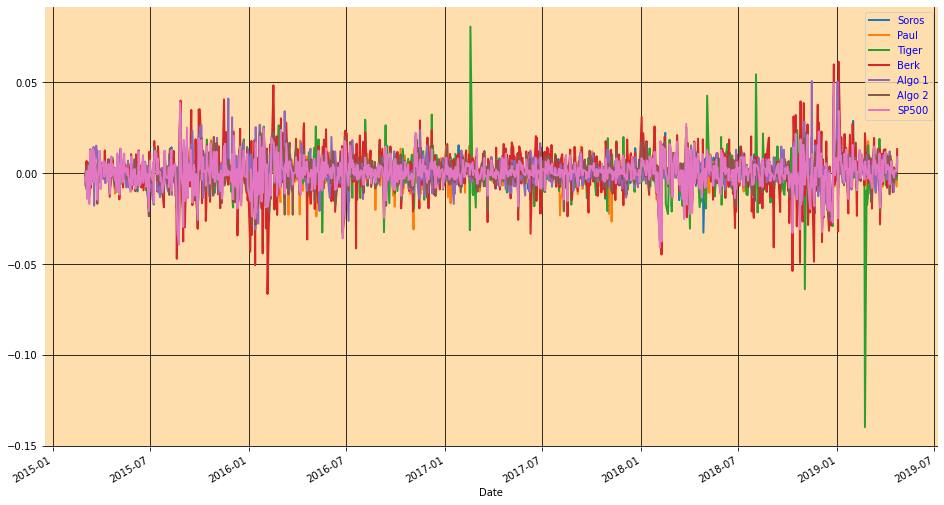

In [15]:
return_daily_concat.plot()

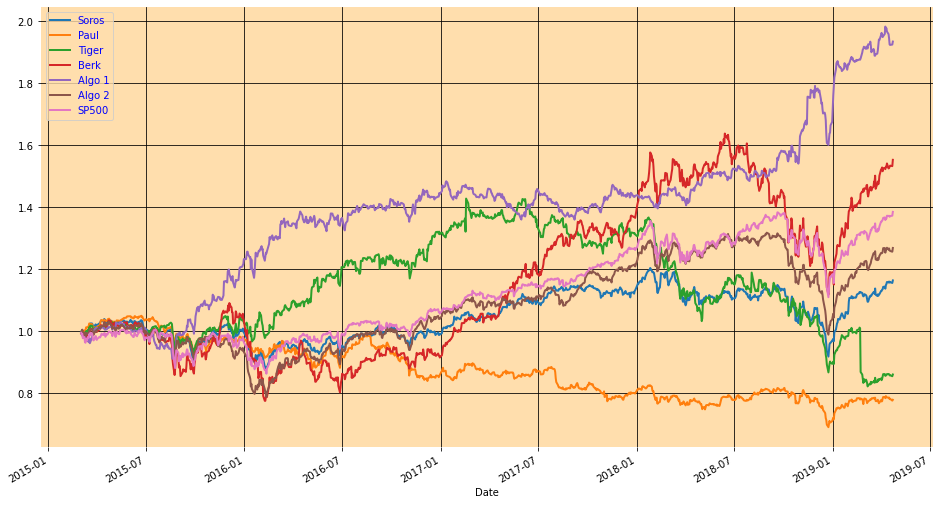

In [16]:
cumulative_returns = (1+return_daily_concat).cumprod()
cumulative_returns.plot()
plt.show()

In [17]:
print(f"The SP500 is trending down, while the 'Algo 1' is taking off. '{Berk}' starts to see great returns until the drop at the begging of 2019, then get's hit the hardest")

The SP500 is trending down, while the 'Algo 1' is taking off. 'BERKSHIRE HATHAWAY INC' starts to see great returns until the drop at the begging of 2019, then get's hit the hardest


## Risk

Determine the _risk_ of each portfolio:

1. Create a box plot for each portfolio. 
2. Calculate the standard deviation for all portfolios
4. Determine which portfolios are riskier than the S&P 500
5. Calculate the Annualized Standard Deviation

### Create a box plot for each of the returns. Which box has the largest spread? Which has the smallest spread?

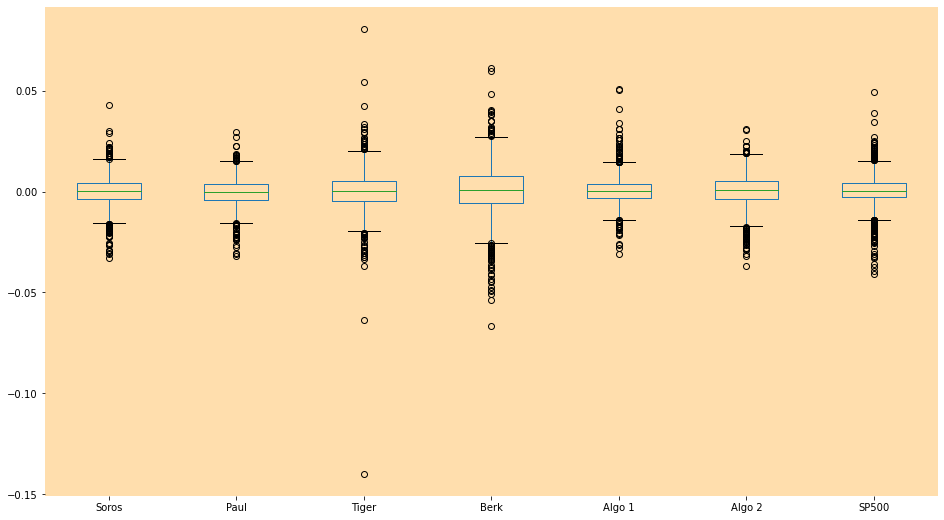

In [18]:
return_daily_concat.boxplot(grid=False)
plt.show()

In [19]:
print(f"'{Tiger}' by far has the largest spread. Followed by '{Berk}', while the SP500 seems to be very steady.")

'TIGER GLOBAL MANAGEMENT LLC' by far has the largest spread. Followed by 'BERKSHIRE HATHAWAY INC', while the SP500 seems to be very steady.


* ***Calculate the standard deviation for each portfolio. Which portfolios are riskier than the S&P 500?***

In [20]:
std = return_daily_concat.std()
std

Soros     0.007895
Paul      0.007023
Tiger     0.010894
Berk      0.012919
Algo 1    0.007620
Algo 2    0.008342
SP500     0.008554
dtype: float64

In [21]:
std > std["SP500"]

Soros     False
Paul      False
Tiger      True
Berk       True
Algo 1    False
Algo 2    False
SP500     False
dtype: bool

In [22]:
print(f"'{Tiger}' and '{Berk}' both have a higher standard deviation then the 'SP500'.")

'TIGER GLOBAL MANAGEMENT LLC' and 'BERKSHIRE HATHAWAY INC' both have a higher standard deviation then the 'SP500'.


* ***Calculate the annualized standard deviation (252 trading days).***

In [23]:
ann_std = std * np.sqrt(252)
ann_std

Soros     0.125335
Paul      0.111488
Tiger     0.172936
Berk      0.205077
Algo 1    0.120967
Algo 2    0.132430
SP500     0.135786
dtype: float64

## Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

1. Plot the rolling standard deviation of the various portfolios along with the rolling standard deviation of the S&P 500 (consider a 21 day window). Does the risk increase for each of the portfolios at the same time risk increases in the S&P?
2. Construct a correlation table for the algorithmic, whale, and S&P 500 returns. Which returns most closely mimic the S&P?
3. Choose one portfolio and plot a rolling beta between that portfolio's returns and S&P 500 returns. Does the portfolio seem sensitive to movements in the S&P 500?
4. An alternative way to calculate a rolling window is to take the exponentially weighted moving average. This is like a moving window average, but it assigns greater importance to more recent observations. Try calculating the ewm with a 21 day half-life.

### 1. Plot the rolling standard deviation of the various portfolios along with the rolling standard deviation of the S&P 500 using a 21 day rolling window. Does the risk increase for each of the portfolios at the same time risk increases in the S&P?

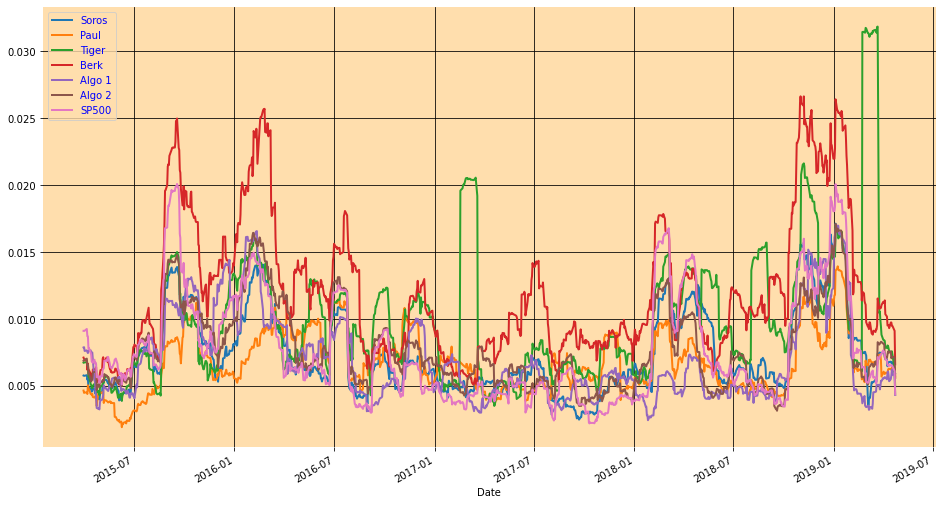

In [24]:
rolling_plot = return_daily_concat.rolling(21).std().plot()

In [25]:
print(f"All portfolios seems to move coherently with a 21 day window, at times the risk for the other portfolios is higher. When the risk of the 'SP500' rises the others tend to follow")

All portfolios seems to move coherently with a 21 day window, at times the risk for the other portfolios is higher. When the risk of the 'SP500' rises the others tend to follow


### 2. Construct a correlation table for the algorithmic, whale, and S&P 500 returns. Which returns most closely mimic the S&P?

In [26]:
corr_table = return_daily_concat.corr()
corr_table

Soros      Paul     Tiger      Berk    Algo 1    Algo 2     SP500
Soros   1.000000  0.699914  0.561243  0.754360  0.321211  0.826873  0.837864
Paul    0.699914  1.000000  0.434479  0.545623  0.268840  0.678152  0.669732
Tiger   0.561243  0.434479  1.000000  0.424423  0.164387  0.507414  0.623946
Berk    0.754360  0.545623  0.424423  1.000000  0.292033  0.688082  0.751371
Algo 1  0.321211  0.268840  0.164387  0.292033  1.000000  0.288243  0.279494
Algo 2  0.826873  0.678152  0.507414  0.688082  0.288243  1.000000  0.858764
SP500   0.837864  0.669732  0.623946  0.751371  0.279494  0.858764  1.000000

In [27]:
print(f"Of all the portfolios 'Algo 1' is runs the closes to SP500 returns. Given that even 'Algo 1' doesn't correlate significantly")

Of all the portfolios 'Algo 1' is runs the closes to SP500 returns. Given that even 'Algo 1' doesn't correlate significantly


### Choose one portfolio and plot a rolling beta between that portfolio's returns and S&P 500 returns. Does the portfolio seem sensitive to movements in the S&P 500?

In [28]:
berk_cov = return_daily_concat["Berk"].cov(return_daily_concat['SP500'])
berk_var = return_daily_concat['Berk'].var()
berk_beta = berk_cov / berk_var
rolling_var = return_daily_concat["SP500"].rolling(window=21).var()

rolling_cov = (return_daily_concat["Berk"].rolling(window=21)
               .cov(return_daily_concat["SP500"]))

rolling_beta = rolling_cov/rolling_var

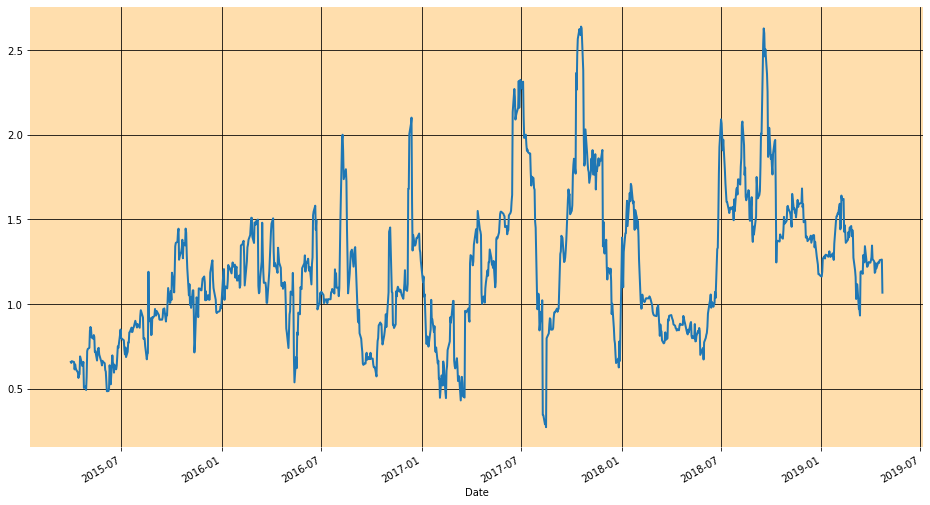

In [29]:
rolling_beta.plot()
plt.show()

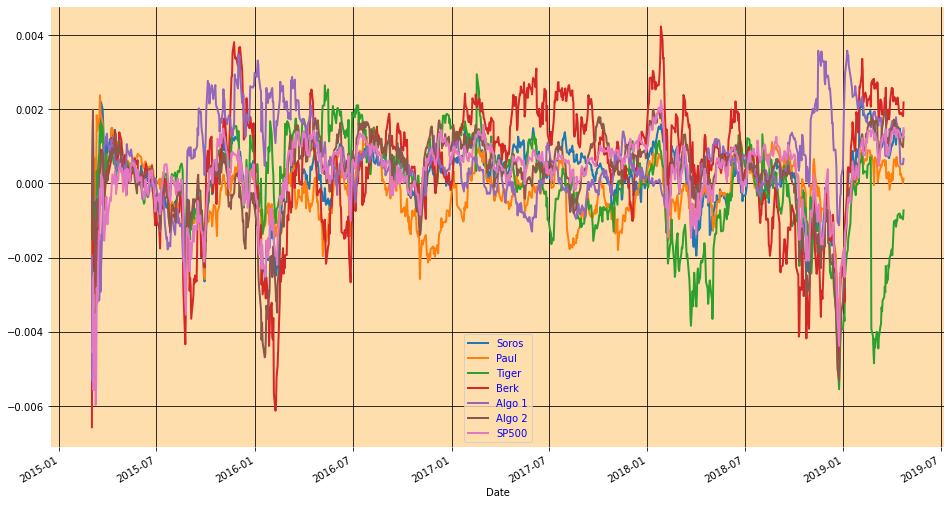

In [30]:
ewm = return_daily_concat.ewm(halflife=21).mean()
ewm.plot()
plt.show()

---

## Sharpe Ratios
In reality, investment managers and thier institutional investors look at the ratio of return-to-risk, and not just returns alone. (After all, if you could invest in one of two portfolios, each offered the same 10% return, yet one offered lower risk, you'd take that one, right?)

1. Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot.
2. Determine whether the algorithmic strategies outperform both the market (S&P 500) and the whales portfolios.

* ***Calculate annualized sharpe ratios***

In [31]:
sharp_ratios = (return_daily_concat.mean()*252/(return_daily_concat.std()*np.sqrt(252)))
sharp_ratios

Soros     0.356417
Paul     -0.483570
Tiger    -0.121060
Berk      0.621810
Algo 1    1.378648
Algo 2    0.501364
SP500     0.648267
dtype: float64

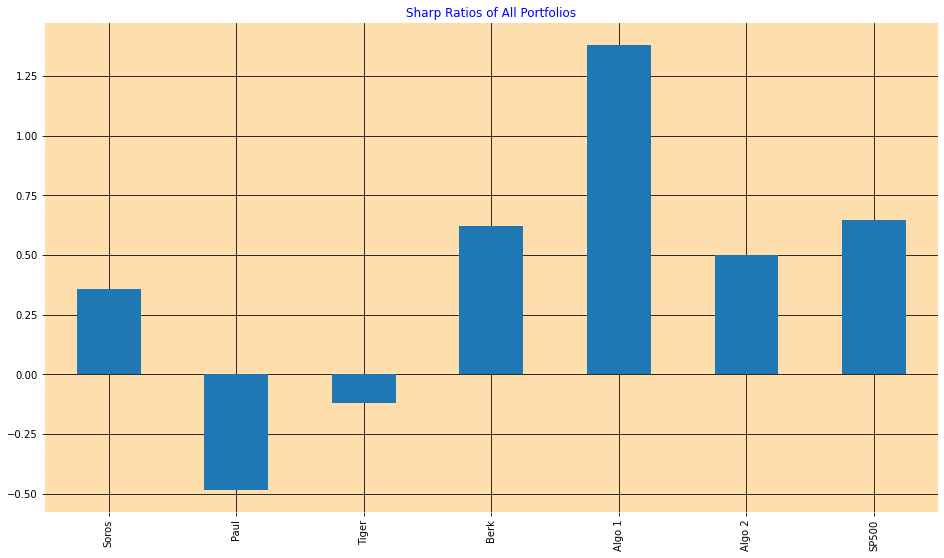

In [32]:
sharp_ratios.plot.bar(title="Sharp Ratios of All Portfolios")

On the basis of this performance metric, do our algo strategies outperform both 'the market' and the whales? Type your answer here:

In [33]:
print(f"Both 'Algo 1' and 'Algo 2' outperform the SP500 by a large margin. '{Soros}', and '{Berk}' seem to be the only ones besides the 'SP500' thats positive.")

Both 'Algo 1' and 'Algo 2' outperform the SP500 by a large margin. 'SOROS FUND MANAGEMENT LLC', and 'BERKSHIRE HATHAWAY INC' seem to be the only ones besides the 'SP500' thats positive.


# Portfolio Returns

In this section, you will build your own portfolio of stocks, calculate the returns, and compare the results to the Whale Portfolios and the S&P 500. 

1. Visit [Google Sheets](https://docs.google.com/spreadsheets/) and use the in-built Google Finance function to choose 3-5 stocks for your own portfolio.
2. Download the data as CSV files and calculate the portfolio returns.
3. Calculate the returns for each stock.
4. Using those returns, calculate the weighted returns for your entire portfolio assuming an equal number of shares for each stock.
5. Add your portfolio returns to the DataFrame with the other portfolios and rerun the analysis. How does your portfolio fair?


## Your analysis should include the following:

- Using all portfolios:
 - The annualized standard deviation (252 trading days) for all portfolios.
 - The plotted rolling standard deviation using a 21 trading day window for all portfolios.
 - The calculated annualized Sharpe Ratios and the accompanying bar plot visualization.
 - A correlation table.
- Using your custom portfolio and one other of your choosing:
 - The plotted beta. 

In [34]:
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_API_SECRET_KEY")
api = tradeapi.REST( alpaca_api_key, alpaca_secret_key, api_version="v2")

In [35]:
return_daily_concat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1043 entries, 2015-03-03 to 2019-04-23
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Soros   1043 non-null   float64
 1   Paul    1043 non-null   float64
 2   Tiger   1043 non-null   float64
 3   Berk    1043 non-null   float64
 4   Algo 1  1043 non-null   float64
 5   Algo 2  1043 non-null   float64
 6   SP500   1043 non-null   float64
dtypes: float64(7)
memory usage: 65.2 KB


In [36]:
ticker = ["TSLA", "FB", "PENN", "AAPL"]
timeframe = "1D"
start_date = pd.Timestamp('2018-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
my_port = api.get_barset( ticker, timeframe, 
                         limit=None, start=start_date, 
                         end=end_date, after=None, 
                         until=None,).df
my_port = my_port.drop( columns=['open', 'high', 'low', 'volume'], level=1)
my_port.reset_index(inplace=True)
my_port["index"] = pd.to_datetime(my_port["index"]).dt.date
my_port.set_index("index",inplace=True)

* ***Plot the Daily Percent change of my portfolio***

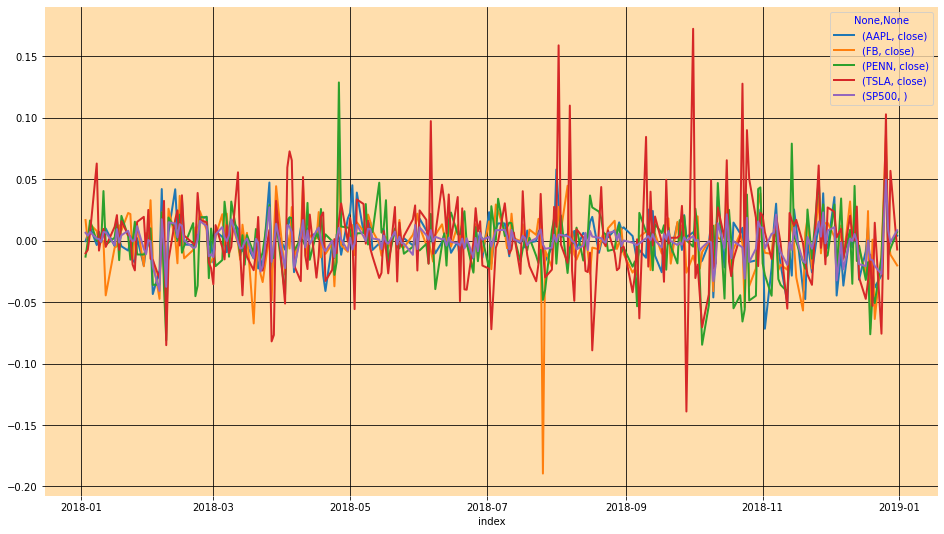

In [37]:
daily_port = my_port.pct_change()
daily_port["SP500"] = return_daily_concat["SP500"]
daily_port.dropna(inplace=True)
daily_port.plot()
plt.show()

* ***Weighted Portfolio Returns***

In [38]:
weights = [1/5, 1/5, 1/5,1/5,1/5]

In [39]:
weighted_returns = (weights*daily_port)
weighted_returns = weighted_returns.sum(axis=1)

In [40]:
df_all = pd.concat([return_daily_concat,weighted_returns], axis=1, join="inner")
df_all["Mine"] = df_all[0]
df_all.drop(columns=0,inplace=True)
df_all.head()

Soros      Paul     Tiger      Berk    Algo 1    Algo 2  \
2018-01-03  0.004658  0.000027  0.001979  0.005676 -0.000890  0.008175   
2018-01-04 -0.000914  0.004196  0.010743  0.004065 -0.000914  0.004294   
2018-01-05  0.004072  0.000823  0.000737  0.022023 -0.003839  0.006405   
2018-01-08  0.004473 -0.003739  0.005085  0.003435  0.001653  0.000658   
2018-01-09 -0.001028  0.000872  0.001789  0.000708 -0.001004 -0.002091   

               SP500      Mine  
2018-01-03  0.006399 -0.000102  
2018-01-04  0.004029 -0.000032  
2018-01-05  0.007034  0.010838  
2018-01-08  0.001662  0.013687  
2018-01-09  0.001303 -0.000311

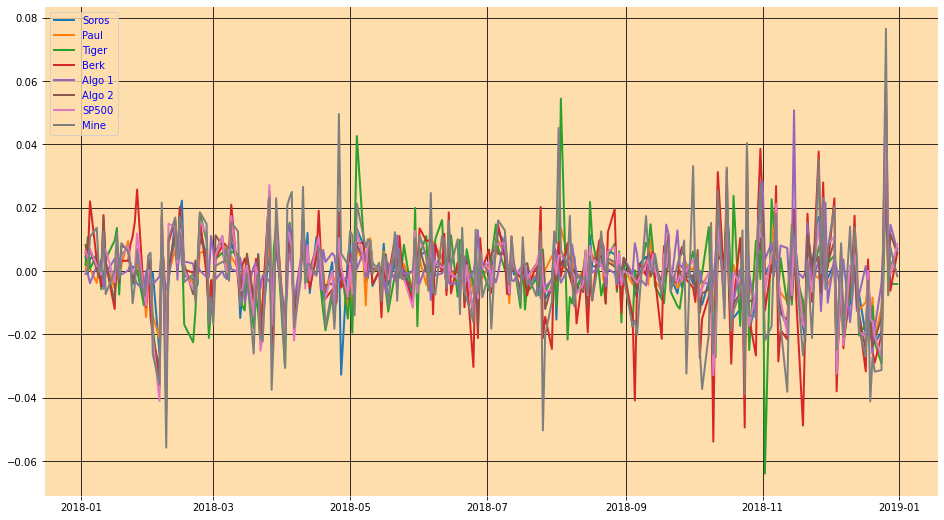

In [41]:
df_all.plot()
plt.show()

* ***Cumulative Returns***

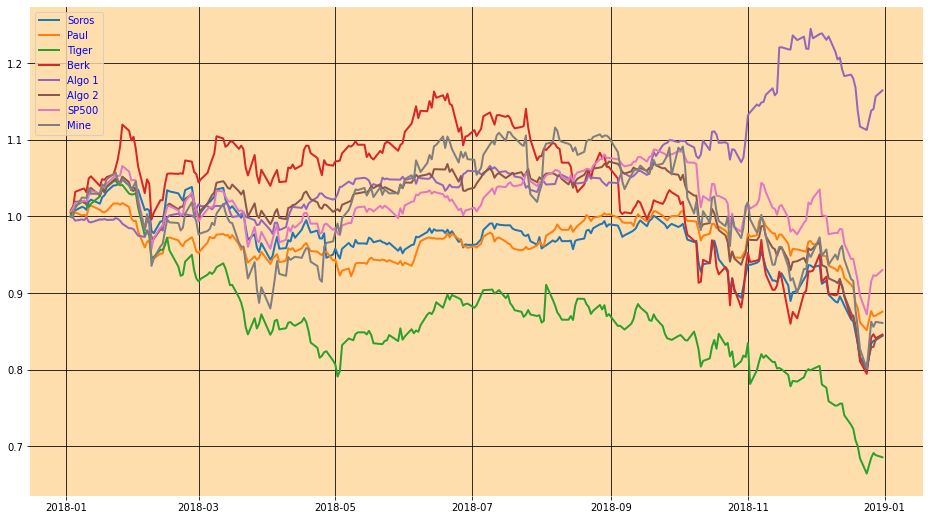

In [42]:
df_my_cum = (1+df_all).cumprod()
df_my_cum.plot()
plt.show()

* ***Boxplot***

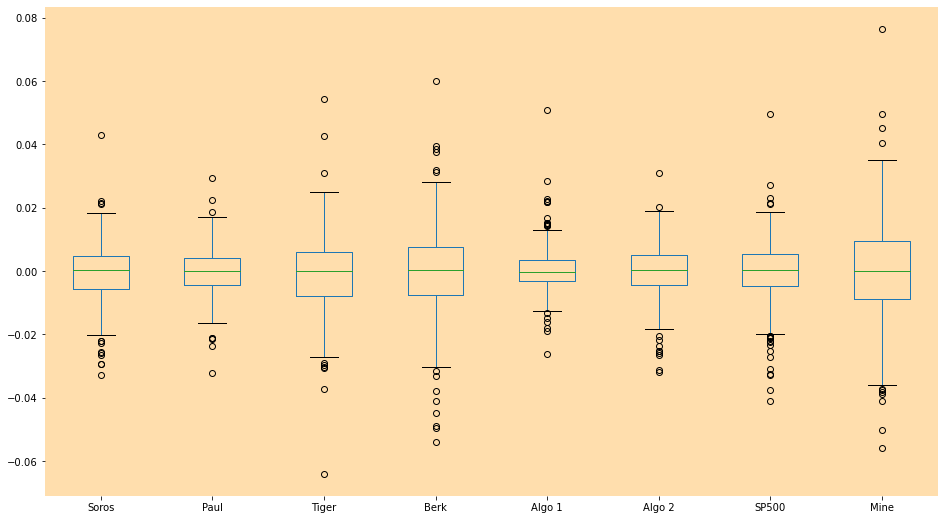

In [43]:
df_all.boxplot(grid=False)
plt.show()

In [44]:
my_std = df_all.std()
print("Standard Deveation table:")
print(my_std)

Standard Deveation table:
Soros     0.009939
Paul      0.007434
Tiger     0.012507
Berk      0.015165
Algo 1    0.007563
Algo 2    0.009004
SP500     0.010750
Mine      0.016530
dtype: float64


In [45]:
my_std > std["SP500"]

Soros      True
Paul      False
Tiger      True
Berk       True
Algo 1    False
Algo 2     True
SP500      True
Mine       True
dtype: bool

***All stocks I selected have a higher volatility rate then the ``SP500``***

* ***Estimated Weighted Moving Average***

In [51]:
my_ewm = daily_port.ewm(halflife=21).mean()


* ***21 Day Standard Devation Moving Average***

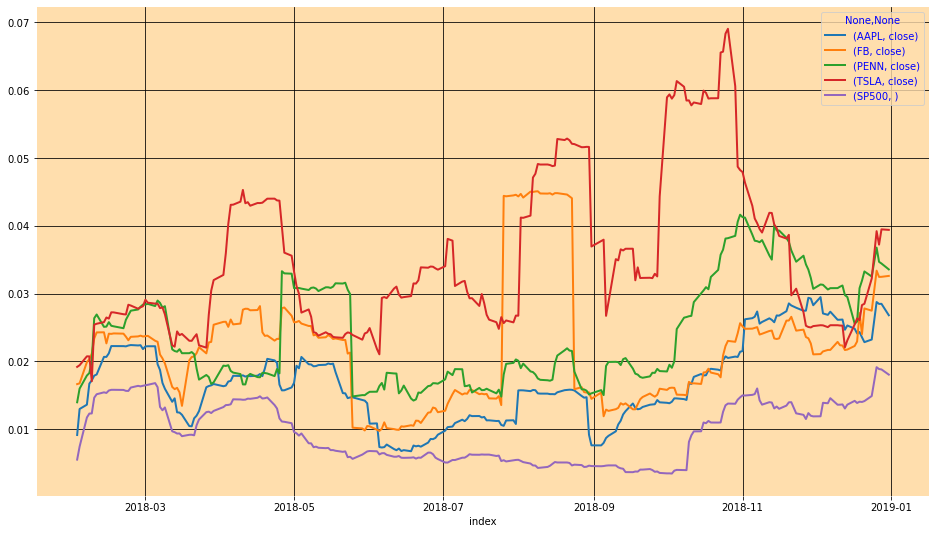

In [47]:
my_rolling_plot = daily_port.rolling(21).std().plot()
my_rolling_plot
plt.show()

* ***Annualized standard deviation***

In [46]:
my_ann_std = my_std * np.sqrt(252)
my_ann_std

Soros     0.157771
Paul      0.118009
Tiger     0.198544
Berk      0.240737
Algo 1    0.120059
Algo 2    0.142928
SP500     0.170643
Mine      0.262411
dtype: float64

* ***Sharp Ratios***

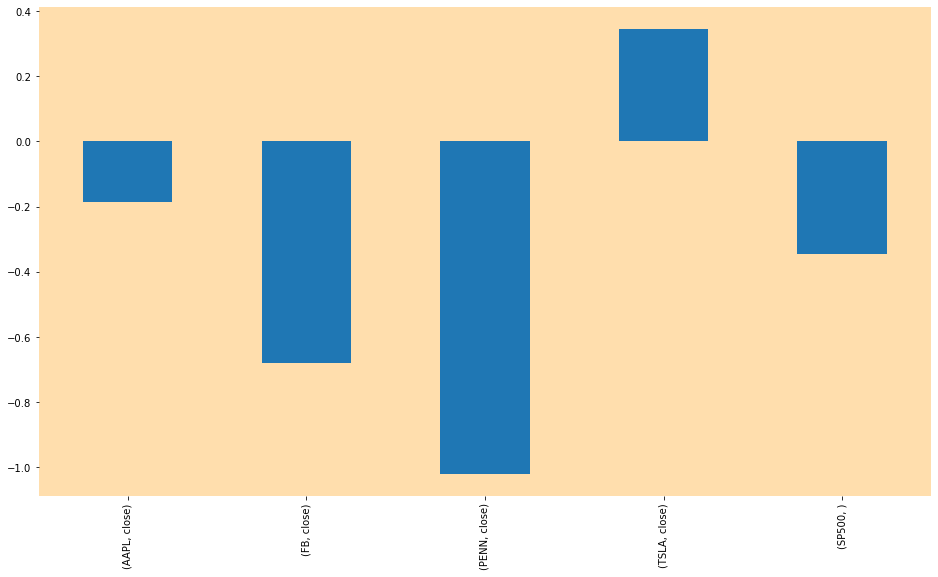

In [52]:
my_sharpe_ratios = (daily_port.mean() * 252) / (daily_port.std() * np.sqrt(252))
my_sharpe_ratios.plot.bar(grid=False)
plt.show()

* ***Correlation table***

In [48]:
my_corr = daily_port.corr()
my_corr

AAPL        FB      PENN      TSLA     SP500
                close     close     close     close          
AAPL  close  1.000000  0.446921  0.387923  0.317009  0.741302
FB    close  0.446921  1.000000  0.477875  0.278859  0.572796
PENN  close  0.387923  0.477875  1.000000  0.183154  0.521641
TSLA  close  0.317009  0.278859  0.183154  1.000000  0.396152
SP500        0.741302  0.572796  0.521641  0.396152  1.000000

* ***Rolling Beta***

In [49]:
my_berk_cov = daily_port["AAPL"]["close"].cov(return_daily_concat['SP500'])
my_berk_var = daily_port['AAPL']["close"].var()
my_berk_beta = my_berk_cov / my_berk_var
my_rolling_var = daily_port["SP500"].rolling(window=21).var()

my_rolling_cov = (daily_port["AAPL"]["close"].rolling(window=21)
               .cov(daily_port["SP500"]))

my_rolling_beta = my_rolling_cov/my_rolling_var

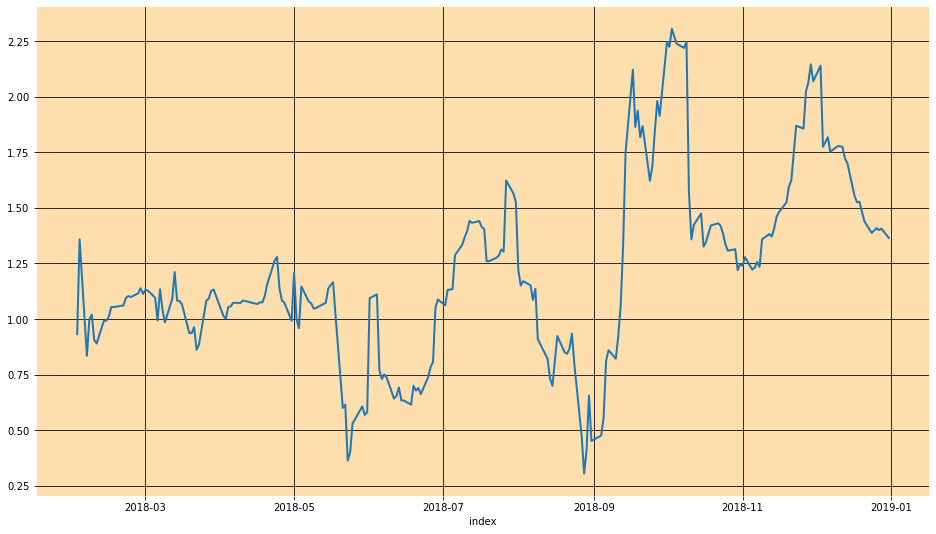

In [50]:
my_rolling_beta.plot()
plt.show()

In [53]:
weights = [1/5, 1/5, 1/5,1/5,1/5]

In [54]:
sum(weights)

1.0

In [55]:
weighted_returns = (weights*daily_port)
port_ret = weighted_returns.sum(axis=1)

In [56]:
port_ret

index
2018-01-03   -0.000102
2018-01-04   -0.000032
2018-01-05    0.010838
2018-01-08    0.013687
2018-01-09   -0.000311
                ...   
2018-12-24   -0.031263
2018-12-26    0.076475
2018-12-27   -0.007681
2018-12-28    0.007495
2018-12-31   -0.001575
Length: 250, dtype: float64